# Lecture 3: Logistic Regression and Text Models
***

<img src="figs/logregwordcloud.png",width=1000,height=50>

### Problem 1: Logistic Regression for 2D Continuous Features 
***

In the video lecture you saw some examples of using logistic regression to do binary classification on text data (SPAM vs HAM) and on 1D continuous data.  In this problem we'll look at logistic regression for 2D continuous data. The data we'll use are <a href="https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg">sepal</a> measurements from the ubiquitous *iris* dataset.  


<p>
<img style="float:left; width:450px" src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg">
</p>


The two features of our model will be the **sepal length** and **sepal width**.  Execute the following cell to see a plot of the data. The blue points correspond to the sepal measurements of the Iris Setosa (left) and the red points correspond to the sepal measurements of the Iris Versicolour (right). 

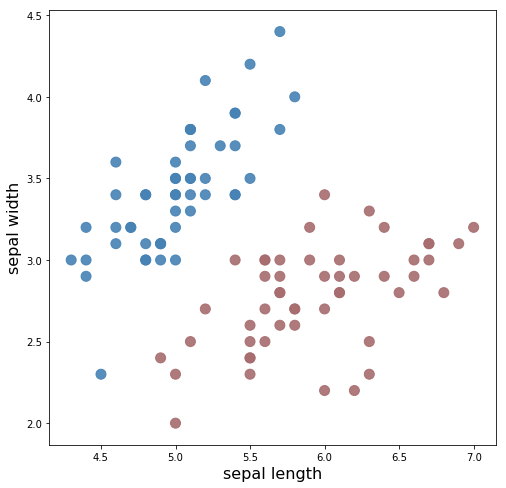

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import datasets

iris = datasets.load_iris()
X_train = iris.data[iris.target != 2, :2] # first two features and
y_train = iris.target[iris.target != 2]   # first two labels only 

fig = plt.figure(figsize=(8,8))
mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
plt.scatter(X_train[:, 0], X_train[:, 1], s=100, alpha=0.9, c=[mycolors["red"] if yi==1 else mycolors["blue"] for yi in y_train])
plt.xlabel('sepal length', fontsize=16)
plt.ylabel('sepal width', fontsize=16);

We'll train a logistic regression model of the form 

$$
p(y = 1 ~|~ {\bf x}; {\bf w}) = \frac{1}{1 + \textrm{exp}[-(w_0 + w_1x_1 + w_2x_2)]}
$$

using **sklearn**'s logistic regression classifier as follows 

In [2]:
from sklearn.linear_model import LogisticRegression # import from sklearn 
logreg = LogisticRegression()                       # initialize classifier 
logreg.fit(X_train, y_train);                       # train on training data 

**Q**: Determine the parameters ${\bf w}$ fit by the model.  It might be helpful to consult the documentation for the classifier on the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">sklearn website</a>. **Hint**: The classifier stores the coefficients and bias term separately. 

**Q**: In general, what does the Logistic Regression decision boundary look like for data with two features?  

**Q**: Modify the code below to plot the decision boundary along with the data. 

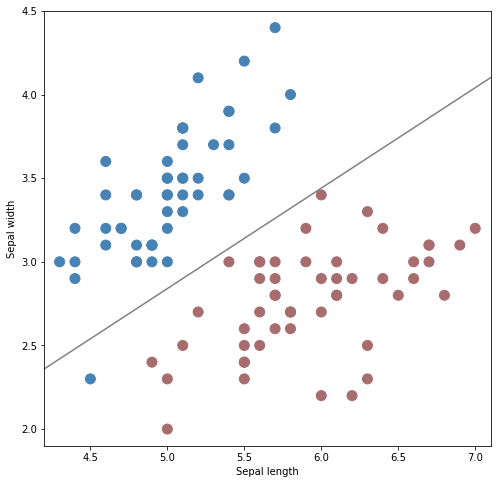

In [3]:
import numpy as np
import math

fig = plt.figure(figsize=(8,8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=100, c=[mycolors["red"] if yi==1 else mycolors["blue"] for yi in y_train])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
x_min, x_max = np.min(X_train[:,0])-0.1, np.max(X_train[:,0])+0.1
y_min, y_max = np.min(X_train[:,1])-0.1, np.max(X_train[:,1])+0.1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

x1 = np.linspace(x_min, x_max, 100)
w0 = logreg.intercept_
w1 = logreg.coef_[0][0]
w2 = logreg.coef_[0][1]
x2 = (-w0 - w1*x1)/w2#TODO 
plt.plot(x1, x2, color="gray");

### Problem 2: The Bag-of-Words Text Model 
***

The remainder of today's exercise will consider the problem of predicting the semantics of text.  In particular, later we'll look at predicting whether movie reviews are positive or negative just based on their text. 

Before we can utilize text as features in a learning model, we need a concise mathematical way to represent things like words, phrases, sentences, etc.  The most common text models are based on the so-called <a href="https://en.wikipedia.org/wiki/Vector_space_model">Vector Space Model</a> (VSM) where individual words in a document are associated with entries of a vector: 

$$
\textrm{"The sky is blue"} \quad \Rightarrow \quad 
\left[
\begin{array}{c}
0 \\
1 \\ 
0 \\
0 \\
1
\end{array}
\right]
$$

The first step in creating a VSM is to define a vocabulary, $V$, of words that you will include in your model.  This vocabulary can be determined by looking at all (or most) of the words in the training set, or even by including a fixed vocabulary based on the english language.  A vector representation of a document like a movie review is then a vector with length $|V|$ where each entry in the vector maps uniquely to a word in the vocabulary. A vector encoding of a document would then be a vector that is nonzero in positions corresponding to words present in the document and zero everywhere else.  How you fill in the nonzero entries depends on the model you're using.  Two simple conventions are the **Bag-of-Words** model and the **binary** model.  

In the binary model we simply set an entry of the vector to $1$ if the associate word appears at least once in the document.  In the more common Bag-of-Words model we set an entry of the vector equal to the frequency with which the word appears in the document. Let's see if we can come up with a simple implementation of the Bag-of-Words model in Python, and then later we'll see how sklearn can do the heavy lifting for us. 

Consider a training set containing three documents, specified as follows 

$\texttt{Training Set}:$

$\texttt{d1}: \texttt{new york times}$

$\texttt{d2}: \texttt{new york post}$

$\texttt{d3}: \texttt{los angeles times}$


First we'll define the vocabulary based on the words in the test set.  It is $V = \{ \texttt{angeles}, \texttt{los}, \texttt{new}, \texttt{post}, \texttt{times}, \texttt{york}\}$. 


We need to define an association between the particular words in the vocabulary and the specific entries in our vectors.  Let's define this association in the order that we've listed them above.  We can store this mapping as a Python dictionary as follows: 

In [4]:
V = {"angeles": 0, "los": 1, "new": 2, "post": 3, "times": 4, "york": 5}

Let's also store the documents in a list as follows: 

In [5]:
D = ["the new york times", "the new york post", "the los angeles times"]

To be consistent with sklearn conventions, we'll encode the documents as *row-vectors* stored in a matrix.  In this case, each row of the matrix corresponds to a document, and each column corresponds to a term in the vocabulary.  For our example this gives us a matrix $M$ of shape $3 \times 6$.  The $(d,t)$-entry in $M$ is then the number of times the term $t$ appears in document $d$

**Q**: Your first task is to write some simple Python code to construct the *term-frequency* matrix $M$ 

In [6]:
M = np.zeros((len(D),len(V)))

for ii, doc in enumerate(D): 
    for term in doc.split(): 
        if(term in V):         #only print if the term is in our dictionary
            M[ii,V[term]] += 1 #TODO
        
print(M)

[[0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 1. 0.]]


Hopefully your code returns the matrix 

$$M = 
\left[
\begin{array}{ccccccc}
0 & 0 & 1 & 0 & 1 & 1 \\
0 & 0 & 1 & 1 & 0 & 1 \\
1 & 1 & 0 & 0 & 1 & 0 \\
\end{array}
\right]$$.  

Note that the entry in the (2,0) position is $1$ because the first word (angeles) appears once in the third document. 

OK, let's see how we can construct the same term-frequency matrix in sklearn.  We will use something called the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">CountVectorizer</a> to accomplish this. Let's see some code and then we'll explain how it functions. 

To avoid common words, such as "the", in our analysis, we will remove any word from a list of common english words in our analysis. We can do so by typing 

    stop_words = 'english'

in the CountVectorizer call.

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.feature_extraction.text import CountVectorizer    # import CountVectorizer 
vectorizer = CountVectorizer(stop_words = 'english')           # initialize the vectorizer
X = vectorizer.fit_transform(D,)                               # fit to training data and transform to matrix 

The $\texttt{fit_transform}$ method actually does two things.  It fits the model to the training data by building a vocabulary.  It then transforms the text in $D$ into matrix form.  

If we wish to see the vocabulary you can do it like so 

In [8]:
print(vectorizer.vocabulary_)

{'new': 2, 'york': 5, 'times': 4, 'post': 3, 'los': 1, 'angeles': 0}


Note that this is the same vocabulary and indexing that we definfed ourselves (just in a different order).  Hopefully that means we'll get the same term-frequency matrix.  We can print $X$ and check 

In [9]:
print(X.todense())

[[0 0 1 0 1 1]
 [0 0 1 1 0 1]
 [1 1 0 0 1 0]]


Yep, they're the same!  Notice that we had to convert $X$ to a dense matrix for printing.  This is because CountVectorizer actually returns a sparse matrix.  This is a very good thing since most vectors in a text model will be **extremely** sparse, since most documents will only contain a handful of words from the vocabulary. 

OK, let's see how we can use the CountVectorizer to transform the test documents into their own term-frequency matrix.

In [10]:
#get a sense of how different the vectors are

for f in X:
    print(euclidean_distances(X[0],f))



[[0.]]
[[1.41421356]]
[[2.]]


OK, now suppose that we have a query document not included in the training set that we want to vectorize.  

In [11]:
d4 = ["new york new tribune"]

We've already fit the CountVectorizer to the training set, so all we need to do is transform the test set documents into a term-frequency vector using the same conventions.  Since we've already fit the model, we do the transformation with the $\texttt{transform}$ method: 

In [12]:
x4 = vectorizer.transform(d4)

Let's print it and see what it looks like 

In [13]:
print(x4.todense())

[[0 0 2 0 0 1]]


Notice that the query document included the word $\texttt{new}$ twice, which corresponds to the entry in the $(0,2)$-position. 

**Q**: What's missing from $x4$ that we might expect to see from the query document? 

<br>

### Problem 3: Term Frequency - Inverse Document Frequency 
***

The Bag-of-Words model for text classification is very popular, but let's see if we can do better.  Currently we're weighting every word in the corpus by it's frequency.  It turns out that in text classification there are often features that are not particularly useful predictors for the document class, either because they are too common or too uncommon.  **Stop-words** are extremely common, low-information words like "a", "the", "as", etc.  Removing these from documents is typically the first thing done in peparing data for document classification. 

**Q**: Can you think of a situation where it might be useful to keep stop words in the corpus? 

Other words that tend to be uninformative predictors are words that appear very very rarely.  In particular, if they do not appear frequently enough in the training data then it is difficult for a classification algorithm to weight them heavily in the classification process. 

In general, the words that tend to be useful predictors are the words that appear frequently, but not too frequently.  Consider the following frequency graph for a corpus. 

<img src="figs/feat_freq.png",width=400,height=50>

The features in column A appear too frequently to be very useful, and the features in column C appear too rarely. One first-pass method of feature selection in text classification would be to discard the words from columns A and C, and build a classifier with only features from column B.

Another common model for identifying the useful terms in a document is the Term Frequency - Inverse Document Frequency (tf-idf) model.  Here we won't throw away any terms, but we'll replace their Bag-of-Words frequency counts with tf-idf scores which we describe below. 

The tf-idf score is the product of two statistics, *term frequency* and *inverse document frequency*


$$\texttt{tfidf(d,t)} = \texttt{tf(d,t)} \times \texttt{idf(t)}$$

The term frequency $\texttt{tf(d,t)}$ is a measure of the frequency with which term $t$ appears in document $d$.  The inverse document frequency $\texttt{idf(t)}$ is a measure of how much information the word provides, that is, whether the term is common or rare across all documents.  By multiplying the two quantities together, we obtain a representation of term $t$ in document $d$ that weighs how common the term is in the document with how common the word is in the entire corpus. You can imagine that the words that get the highest associated values are terms that appear many times in a small number of documents. 


There are many ways to compute the composite terms $\texttt{tf}$ and $\texttt{idf}$.  For simplicity, we'll define $\texttt{tf(d,t)}$ to be the number of times term $t$ appears in document $d$ (i.e., Bag-of-Words). We will define the inverse document frequency as follows: 

$$
\texttt{idf(t)} = \ln ~ \frac{\textrm{total # documents}}{\textrm{1 + # documents with term }t}
 = \ln ~ \frac{|D|}{|d: ~ t \in d |}
$$

Note that we could have a potential problem if a term comes up that is not in any of the training documents, resulting  in a divide by zero.  This might happen if you use a canned vocabulary instead of constructing one from the training documents.  To guard against this, many implementations will use add-one smoothing in the denominator (this is what sklearn does). 

$$
\texttt{idf(t)} = \ln ~ \frac{\textrm{total # documents}}{\textrm{1 + # documents with term }t}
 = \ln ~ \frac{|D|}{1 + |d: ~ t \in d |}
$$

**Q**: Compute $\texttt{idf(t)}$ (without smoothing) for each of the terms in the training documents from the previous problem

**Q**: Compute the td-ifd matrix for the training set 

In [ ]:
idf = np.array([np.log(3), np.log(3), np.log(3./2), np.log(3), np.log(3./2), np.log(3./2)])
Xtfidf = np.dot(X.todense(), np.diag(idf))

Hopefully you got something like the following: 

$$
X_{tfidf} = 
\left[
\begin{array}{ccccccccc}
0.          & 0.         &  0.40546511 &  0.         &  0.40546511 &  0.40546511 \\
0.          & 0.         &  0.40546511 &  1.09861229 &  0.         &  0.40546511 \\
1.09861229  & 1.09861229 &  0.         &  0.         &  0.40546511 &  0.        
\end{array}
\right]
$$

The final step in any VSM method is the normalization of the vectors.  This is done so that very long documents to not completely overpower the small and medium length documents.  

In [ ]:
row_norms = np.array([np.linalg.norm(row) for row in Xtfidf])
X_tfidf_n = np.dot(np.diag(1./row_norms), Xtfidf)

In [ ]:
print(X_tfidf_n)

Let's see what we get when we use sklearn.  Sklearn has a vectorizer called TfidfVectorizer which is similar to CountVectorizer, but it computes tf-idf scores.  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
Y = tfidf.fit_transform(D)
print(Y.todense())

Note that these are not quite the same, because sklearn's implementation of tf-idf uses the add-one smoothing in the denominator for idf. 

Okay, now let's see if we can use TFIDF analysis on real text documents!

Run the following code to use this analysis on his inauguration speech from 2009. It will output what TFIDF thinks are the most important words from each paragraph

**Q**: Is the analysis able to pick out the most important words correctly? Why does it sometimes pick the wrong words?

**Q**: You can do the same analysis for his 2012 State of the Union Speech by replacing the first line of code with "obama_SOU_2012.txt". How does the analysis do here?

**Q**: Find some other piece of text on your own and do the same analysis here by saving it in .txt file and entering the name of this file in the first line of code. You can find a big source of speeches [http://www.americanrhetoric.com/newtop100speeches.htm](here).

In [ ]:
#load in text
ObamaText = open("obama_SOU_2012.txt").readlines()

#create TFIDF matrix
X = vectorizer.fit_transform(ObamaText)
D_tot = X.shape[0]
Xtfidf = np.zeros(X.shape)

for i,col in enumerate(X.T): #loop over rows of X (i.e. paragraphs of text)
    
    #number of lines the word appears in (no need for smoothing here)
    freq = np.count_nonzero(col.todense())    
    #compute theidf
    idf = math.log(D_tot/(freq))
    #calculate the tf-idf
    Xtfidf[:,i:i+1] = X[:,i].todense()*idf

#normalize Xtfidf matrix
row_norms = np.array([np.linalg.norm(row) for row in Xtfidf])
Xtfidf_norm = np.dot(np.diag(1./row_norms),Xtfidf)

#create a list from the dictionary
V_words, V_nums = vectorizer.vocabulary_.keys(), vectorizer.vocabulary_.values()
V_reverse = zip(V_nums,V_words)
V_reverse_dict = dict(V_reverse)

#loop through the paragraphs of the text and print most important word
for i,row in enumerate(Xtfidf_norm):
    row_str = " "
    row_str = row_str + V_reverse_dict[np.argmax(row)]
    #top_words_ind = np.argsort(row)[-5:]
    #for ii in top_words_ind:
    #    row_str = row_str + V_reverse_dict[ii] + " "
    
    print("The top word in paragraph " + str(i) + " is " + row_str)
    


<br>

### Problem 4: Classifying Semantics in Movie Reviews
***
> The data for this problem was taken from the <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words">Bag of Words Meets Bag of Popcorn</a> Kaggle competition

In this problem you will use the text from movie reviews to predict whether the reviewer felt positively or negatively about the movie using Bag-of-Words and tf-idf. I've partially cleaned the data and stored it in files called $\texttt{labeledTrainData.tsv}$ and $\texttt{labeledTestData.tsv}$ in the data directory.

In [ ]:
import csv 

def read_and_clean_data(fname, remove_stops=True):
    
    with open('data/stopwords.txt', 'rt') as f:
        stops = [line.rstrip('\n') for line in f]
    
    with open(fname,'rt') as tsvin:
        reader = csv.reader(tsvin, delimiter='\t')
        labels = []; text = [] 
        for ii, row in enumerate(reader):
            labels.append(int(row[0]))
            words = row[1].lower().split()
            words = [w for w in words if not w in stops] if remove_stops else words 
            text.append(" ".join(words))
    
    return text, labels

text_train, labels_train = read_and_clean_data('data/labeledTrainData.tsv', remove_stops=True)
text_test, labels_test = read_and_clean_data('data/labeledTestData.tsv', remove_stops=True)

The current parameters are set to not remove stop words from the text so that it's a bit easier to explore. 

 Look at a few of the reviews stored in $\texttt{text_train}$ as well as their associated labels in $\texttt{labels_train}$.  Can you figure out which label refers to a positive review and which refers to a negative review? 

In [ ]:
labels_train[:4]

The first review is labeled $1$ and has the following text: 

In [ ]:
text_train[1]

The fourth review is labeled $0$ and has the following text: 

In [ ]:
text_train[0]

Hopefully it's obvious that label 1 corresponds to positive reviews and label 0 to negative reviews! 

OK, the first thing we'll do is train a logistic regression classifier using the Bag-of-Words model, and see what kind of accuracy we can get.  To get started, we need to vectorize the text into mathematical features that we can use.  We'll use CountVectorizer to do the job. (Before starting, I'm going to reload the data and remove the stop words this time)

In [ ]:
text_train, labels_train = read_and_clean_data('data/labeledTrainData.tsv', remove_stops=True)
text_test, labels_test = read_and_clean_data('data/labeledTestData.tsv', remove_stops=True)

cvec = CountVectorizer()
X_bw_train = cvec.fit_transform(text_train)
y_train = np.array(labels_train)
X_bw_test  = cvec.transform(text_test)
y_test  = np.array(labels_test)

**Q**: How many different words are in the vocabulary? 

OK, now we'll train a logistic regression classifier on the training set, and test the accuracy on the test set.  To do this we'll need to load some kind of accuracy metric from sklearn.  


In [ ]:
from sklearn.metrics import accuracy_score
bwLR = LogisticRegression()
bwLR.fit(X_bw_train, y_train)
pred_bwLR = bwLR.predict(X_bw_test)

print("Logistic Regression accuracy with Bag-of-Words: " + str(accuracy_score(y_test, pred_bwLR)))

OK, so we got an accuracy of around 81% using Bag-of-Words.  Now lets do the same tests but this time with tf-idf features. 

In [ ]:
tvec = TfidfVectorizer()
X_tf_train = tvec.fit_transform(text_train)
X_tf_test  = tvec.transform(text_test)

tfLR = LogisticRegression()
tfLR.fit(X_tf_train, y_train)
pred_tfLR = tfLR.predict(X_tf_test)

print("Logistic Regression accuracy with tf-idf: " + str(accuracy_score(y_test, pred_tfLR)))

**WOOHOO**!  With tf-idf features we got around 85% accuracy, which is a 4% improvement. (If you're scoffing at this, wait until you get some more experience working with real-world data.  4% improvement is pretty awesome).  

**Q**: Which words are the strongest predictors for a positive review and which words are the strongest predictors for negative reviews? I'm not going to give you the answer to this one because it's the same question we'll ask on the next homework assignment. But if you figure this out you'll have a great head start! 

<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
## Notebook Solutions
***
<br><br><br>

### Problem 1: Logistic Regression for 2D Continuous Features 
***

In the video lecture you saw some examples of using logistic regression to do binary classification on text data (SPAM vs HAM) and on 1D continuous data.  In this problem we'll look at logistic regression for 2D continuous data. The data we'll use are <a href="https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg">sepal</a> measurements from the ubiquitous *iris* dataset.  


<!---
<img style="float:left; width:450px" src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg",width=300,height=50>
-->

<img style="float:left; width:450px" src="http://www.twofrog.com/images/iris38a.jpg",width=300,height=50>

<!---
<img style="float:right; width:490px" src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg",width=300,height=50>
-->

<img style="float:right; width:490px" src="http://blazingstargardens.com/wp-content/uploads/2016/02/Iris-versicolor-Blue-Flag-Iris1.jpg",width=300,height=62>


The two features of our model will be the **sepal length** and **sepal width**.  Execute the following cell to see a plot of the data. The blue points correspond to the sepal measurements of the Iris Setosa (left) and the red points correspond to the sepal measurements of the Iris Versicolour (right). 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import datasets

iris = datasets.load_iris()
X_train = iris.data[iris.target != 2, :2] # first two features and
y_train = iris.target[iris.target != 2]   # first two labels only 

fig = plt.figure(figsize=(8,8))
mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
plt.scatter(X_train[:, 0], X_train[:, 1], s=100, alpha=0.9, c=[mycolors["red"] if yi==1 else mycolors["blue"] for yi in y_train])
plt.xlabel('sepal length', fontsize=16)
plt.ylabel('sepal width', fontsize=16);

We'll train a logistic regression model of the form 

$$
p(y = 1 ~|~ {\bf x}; {\bf w}) = \frac{1}{1 + \textrm{exp}[-(w_0 + w_1x_1 + w_2x_2)]}
$$

using **sklearn**'s logistic regression classifier as follows 

In [ ]:
from sklearn.linear_model import LogisticRegression # import from sklearn 
logreg = LogisticRegression()                       # initialize classifier 
logreg.fit(X_train, y_train);                       # train on training data 

**Q**: Determine the parameters ${\bf w}$ fit by the model.  It might be helpful to consult the documentation for the classifier on the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">sklearn website</a>. **Hint**: The classifier stores the coefficients and bias term separately. 

**A**: The bias term is stored in logreg.intercept\_ . The remaining coefficients are stored in logreg.coef\_ . For this problem we have 

$$
w_0 =-0.599, \quad w_1 = 2.217, \quad \textrm{and} \quad w_2 =  -3.692
$$

**Q**: In general, what does the Logistic Regression decision boundary look like for data with two features?  

**A**: The decision boundary for Logistic Regresion for data with two features is a line.  To see this, remember that the decision boundary is made up of $(x_1, x_2)$ points such that $\textrm{sigm}({\bf w}^T{\bf x}) = 0.5$.  We then have 

$$
\frac{1}{1 + \textrm{exp}[-(w_0 + w_1x_1 + w_2x_2)]} = \frac{1}{2} ~~\Rightarrow ~~ w_0 + w_1x_1 + w_2x_2 = 0 ~~\Rightarrow~~ x_2 = -\frac{w_1}{w_2}x_1 - \frac{w_0}{w_2}
$$

So the decision boundary is a line with slope $-w_1/w_2$ and intercept $-w_0/w_2$. 

**Q**: Modify the code below to plot the decision boundary along with the data. 

In [ ]:
import numpy as np

fig = plt.figure(figsize=(8,8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=100, c=[mycolors["red"] if yi==1 else mycolors["blue"] for yi in y_train])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
x_min, x_max = np.min(X_train[:,0])-0.1, np.max(X_train[:,0])+0.1
y_min, y_max = np.min(X_train[:,1])-0.1, np.max(X_train[:,1])+0.1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

x1 = np.linspace(x_min, x_max, 100)
w0 = logreg.intercept_
w1 = logreg.coef_[0][0]
w2 = logreg.coef_[0][1]
x2 = -(w0/w2) - (w1/w2)*x1 #TODO 
plt.plot(x1, x2, color="gray");

### Problem 2: The Bag-of-Words Text Model 
***

The remainder of today's exercise will consider the problem of predicting the semantics of text.  In particular, later we'll look at predicting whether movie reviews are positive or negative just based on their text. 

Before we can utilize text as features in a learning model, we need a concise mathematical way to represent things like words, phrases, sentences, etc.  The most common text models are based on the so-called <a href="https://en.wikipedia.org/wiki/Vector_space_model">Vector Space Model</a> (VSM) where individual words in a document are associated with entries of a vector: 

$$
\textrm{"The sky is blue"} \quad \Rightarrow \quad 
\left[
\begin{array}{c}
0 \\
1 \\ 
0 \\
0 \\
1
\end{array}
\right]
$$

The first step in creating a VSM is to define a vocabulary, $V$, of words that you will include in your model.  This vocabulary can be determined by looking at all (or most) of the words in the training set, or even by including a fixed vocabulary based on the english language.  A vector representation of a document like a movie review is then a vector with length $|V|$ where each entry in the vector maps uniquely to a word in the vocabulary. A vector encoding of a document would then be a vector that is nonzero in positions corresponding to words present in the document and zero everywhere else.  How you fill in the nonzero entries depends on the model you're using.  Two simple conventions are the **Bag-of-Words** model and the **binary** model.  

In the binary model we simply set an entry of the vector to $1$ if the associate word appears at least once in the document.  In the more common Bag-of-Words model we set an entry of the vector equal to the frequency with which the word appears in the document. Let's see if we can come up with a simple implementation of the Bag-of-Words model in Python, and then later we'll see how sklearn can do the heavy lifting for us. 

Consider a training set containing three documents, specified as follows 

$\texttt{Training Set}:$

$\texttt{d1}: \texttt{new york times}$

$\texttt{d2}: \texttt{new york post}$

$\texttt{d3}: \texttt{los angeles times}$


First we'll define the vocabulary based on the words in the test set.  It is $V = \{ \texttt{angeles}, \texttt{los}, \texttt{new}, \texttt{post}, \texttt{times}, \texttt{york}\}$. 


We need to define an association between the particular words in the vocabulary and the specific entries in our vectors.  Let's define this association in the order that we've listed them above.  We can store this mapping as a Python dictionary as follows: 

In [ ]:
V = {"angeles": 0, "los": 1, "new": 2, "post": 3, "times": 4, "york": 5}

Let's also store the documents in a list as follows: 

In [ ]:
D = ["new york times", "new york post", "los angeles times"]

To be consistent with sklearn conventions, we'll encode the documents as *row-vectors* stored in a matrix.  In this case, each row of the matrix corresponds to a document, and each column corresponds to a term in the vocabulary.  For our example this gives us a matrix $M$ of shape $3 \times 6$.  The $(d,t)$-entry in $M$ is then the number of times the term $t$ appears in document $d$

**Q**: Your first task is to write some simple Python code to construct the *term-frequency* matrix $M$ 

In [ ]:
M = np.zeros((len(D),len(V)))

for ii, doc in enumerate(D): 
    for term in doc.split(): 
        M[ii, V[term]] += 1
        
print M

Hopefully your code returns the matrix 

$$M = 
\left[
\begin{array}{ccccccc}
0 & 0 & 1 & 0 & 1 & 1 \\
0 & 0 & 1 & 1 & 0 & 1 \\
1 & 1 & 0 & 0 & 1 & 0 \\
\end{array}
\right]$$.  

Note that the entry in the (2,0) position is $1$ because the first word (angeles) appears once in the third document. 

OK, let's see how we can construct the same term-frequency matrix in sklearn.  We will use something called the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">CountVectorizer</a> to accomplish this. Let's see some code and then we'll explain how it functions. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer    # import CountVectorizer 
vectorizer = CountVectorizer()                                 # initialize the vectorizer
X = vectorizer.fit_transform(D)                                # fit to training data and transform to matrix 

The $\texttt{fit_transform}$ method actually does two things.  It fits the model to the training data by building a vocabulary.  It then transforms the text in $D$ into matrix form.  

If we wish to see the vocabulary you can do it like so 

In [ ]:
print vectorizer.vocabulary_

Note that this is the same vocabulary and indexing that we definfed ourselves.  Hopefully that means we'll get the same term-frequency matrix.  We can print $X$ and check 

In [ ]:
print X.todense()

Yep, they're the same!  Notice that we had to convert $X$ to a dense matrix for printing.  This is because CountVectorizer actually returns a sparse matrix.  This is a very good thing since most vectors in a text model will be **extremely** sparse, since most documents will only contain a handful of words from the vocabulary. 


OK, now suppose that we have a query document not included in the training set that we want to vectorize.  

In [ ]:
d4 = ["new york new tribune"]

We've already fit the CountVectorizer to the training set, so all we need to do is transform the test set documents into a term-frequency vector using the same conventions.  Since we've already fit the model, we do the transformation with the $\texttt{transform}$ method: 

In [ ]:
x4 = vectorizer.transform(d4)

Let's print it and see what it looks like 

In [ ]:
print x4.todense()

Notice that the query document included the word $\texttt{new}$ twice, which corresponds to the entry in the $(0,2)$-position. 

**Q**: What's missing from $x4$ that we might expect to see from the query document? 

**A**: The word $\texttt{tribune}$ do not appear in vector $x4$ at all.  This is because it did not occur in the training set, which means it is not present in the VSM vocabulary.  This should not bother us too much.  Most reasonable text data sets will have most of the important words present in the training set and thus in the vocabulary.  On the other hand, the throw-away words that are present only in the test set are probably useless anyway, since the learning model is trained based on the text in the training set, and thus won't be able to do anything intelligent with words the model hasn't seen yet. 

<br>

### Problem 3: Term Frequency - Inverse Document Frequency 
***

The Bag-of-Words model for text classification is very popular, but let's see if we can do better.  Currently we're weighting every word in the corpus by it's frequency.  It turns out that in text classification there are often features that are not particularly useful predictors for the document class, either because they are too common or too uncommon.  **Stop-words** are extremely common, low-information words like "a", "the", "as", etc.  Removing these from documents is typically the first thing done in peparing data for document classification. 

**Q**: Can you think of a situation where it might be useful to keep stop words in the corpus? 

**A**: If you plan to use bi-grams or tri-grams as features.  Bi-grams are pairs of words that appear side-by-side in a document, e.g. "he went", "went to", "to the", "the store". 


Other words that tend to be uninformative predictors are words that appear very very rarely.  In particular, if they do not appear frequently enough in the training data then it is difficult for a classification algorithm to weight them heavily in the classification process. 

In general, the words that tend to be useful predictors are the words that appear frequently, but not too frequently.  Consider the following frequency graph for a corpus. 

<img src="figs/feat_freq.png",width=400,height=50>

The features in column A appear too frequently to be very useful, and the features in column C appear too rarely. One first-pass method of feature selection in text classification would be to discard the words from columns A and C, and build a classifier with only features from column B.

Another common model for identifying the useful terms in a document is the Term Frequency - Inverse Document Frequency (tf-idf) model.  Here we won't throw away any terms, but we'll replace their Bag-of-Words frequency counts with tf-idf scores which we describe below. 

The tf-idf score is the product of two statistics, *term frequency* and *inverse document frequency*


$$\texttt{tfidf(d,t)} = \texttt{tf(d,t)} \times \texttt{idf(t)}$$

The term frequency $\texttt{tf(d,t)}$ is a measure of the frequency with which term $t$ appears in document $d$.  The inverse document frequency $\texttt{idf(t)}$ is a measure of how much information the word provides, that is, whether the term is common or rare across all documents.  By multiplying the two quantities together, we obtain a representation of term $t$ in document $d$ that weighs how common the term is in the document with how common the word is in the entire corpus. You can imagine that the words that get the highest associated values are terms that appear many times in a small number of documents. 


There are many ways to compute the composite terms $\texttt{tf}$ and $\texttt{idf}$.  For simplicity, we'll define $\texttt{tf(d,t)}$ to be the number of times term $t$ appears in document $d$ (i.e., Bag-of-Words). We will define the inverse document frequency as follows: 

$$
\texttt{idf(t)} = \ln ~ \frac{\textrm{total # documents}}{\textrm{# documents with term }t}
 = \ln ~ \frac{|D|}{|d: ~ t \in d |}
$$

Note that we could have a potential problem if a term comes up that is not in any of the training documents, resulting  in a divide by zero.  This might happen if you use a canned vocabulary instead of constructing one from the training documents.  To guard against this, many implementations will use add-one smoothing in the denominator (this is what sklearn does). 

$$
\texttt{idf(t)} = \ln ~ \frac{\textrm{total # documents}}{\textrm{1 + # documents with term }t}
 = \ln ~ \frac{|D|}{1 + |d: ~ t \in d |}
$$

**Q**: Compute $\texttt{idf(t)}$ (without smoothing) for each of the terms in the training documents from the previous problem

**A**: 

$
\texttt{idf}(\texttt{angeles}) = \ln ~ \frac{3}{1} = \ln ~ \frac{3}{1} = 1.10
$

$
\texttt{idf}(\texttt{los}) = \ln ~ \frac{3}{1} = \ln ~ \frac{3}{1} = 1.10
$

$
\texttt{idf}(\texttt{new}) = \ln ~ \frac{3}{2} = \ln ~ \frac{3}{2} = 0.41
$

$
\texttt{idf}(\texttt{post}) = \ln ~ \frac{3}{1} = \ln ~ \frac{3}{1} = 1.10
$

$
\texttt{idf}(\texttt{times}) = \ln ~ \frac{3}{2} = \ln ~ \frac{3}{2} = 0.41
$

$
\texttt{idf}(\texttt{york}) = \ln ~ \frac{3}{2} = \ln ~ \frac{3}{2} = 0.41
$


**Q**: Compute the td-ifd matrix for the training set 

**A**: There are several ways to do this.  One way would be to multiply the term-frequency matrix on the right with a diagonal matrix with the idf-values on the main diagonal 

In [ ]:
idf = np.array([np.log(3), np.log(3), np.log(3./2), np.log(3), np.log(3./2), np.log(3./2)])
Xtfidf = np.dot(X.todense(), np.diag(idf))

In [ ]:
print Xtfidf

Hopefully you got something like the following: 

$$
X_{tfidf} = 
\left[
\begin{array}{ccccccccc}
0.          & 0.         &  0.40546511 &  0.         &  0.40546511 &  0.40546511 \\
0.          & 0.         &  0.40546511 &  1.09861229 &  0.         &  0.40546511 \\
1.09861229  & 1.09861229 &  0.         &  0.         &  0.40546511 &  0.        
\end{array}
\right]
$$

The final step in any VSM method is the normalization of the vectors.  This is done so that very long documents to not completely overpower the small and medium length documents.  

In [ ]:
row_norms = np.array([np.linalg.norm(row) for row in Xtfidf])
X_tfidf_n = np.dot(np.diag(1./row_norms), Xtfidf)

In [ ]:
print X_tfidf_n

Let's see what we get when we use sklearn.  Sklearn has a vectorizer called TfidfVectorizer which is similar to CountVectorizer, but it computes tf-idf scores.  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
Y = tfidf.fit_transform(D)
print Y.todense()

Note that these are not quite the same, becuase sklearn's implementation of tf-idf uses the add-one smoothing in the denominator for idf. 

<br>

### Problem 4: Classifying Semantics in Movie Reviews
***
> The data for this problem was taken from the <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words">Bag of Words Meets Bag of Popcorn</a> Kaggle competition

In this problem you will use the text from movie reviews to predict whether the reviewer felt positively or negatively about the movie using Bag-of-Words and tf-idf. I've partially cleaned the data and stored it in files called $\texttt{labeledTrainData.tsv}$ and $\texttt{labeledTestData.tsv}$ in the data directory.

In [ ]:
import csv 

def read_and_clean_data(fname, remove_stops=True):
    
    with open('data/stopwords.txt', 'r') as f:
        stops = [line.rstrip('\n') for line in f]
    
    with open(fname,'rb') as tsvin:
        reader = csv.reader(tsvin, delimiter='\t')
        labels = []; text = [] 
        for ii, row in enumerate(reader):
            labels.append(int(row[0]))
            words = row[1].lower().split()
            words = [w for w in words if not w in stops] if remove_stops else words 
            text.append(" ".join(words))
    
    return text, labels

text_train, labels_train = read_and_clean_data('data/labeledTrainData.tsv', remove_stops=False)
text_test, labels_test = read_and_clean_data('data/labeledTestData.tsv', remove_stops=False)

The current parameters are set to not remove stop words from the text so that it's a bit easier to explore. 

**Q**: Look at a few of the reviews stored in $\texttt{text_train}$ as well as their associated labels in $\texttt{labels_train}$.  Can you figure out which label refers to a positive review and which refers to a negative review? 

**A**: 

In [ ]:
labels_train[:4]

The first review is labeled $1$ and has the following text: 

In [ ]:
text_train[0]

The fourth review is labeled $0$ and has the following text: 

In [ ]:
text_train[3]

Hopefully it's obvious that label 1 corresponds to positive reviews and label 0 to negative reviews! 

OK, the first thing we'll do is train a logistic regression classifier using the Bag-of-Words model, and see what kind of accuracy we can get.  To get started, we need to vectorize the text into mathematical features that we can use.  We'll use CountVectorizer to do the job. (Before starting, I'm going to reload the data and remove the stop words this time)

In [ ]:
text_train, labels_train = read_and_clean_data('data/labeledTrainData.tsv', remove_stops=True)
text_test, labels_test = read_and_clean_data('data/labeledTestData.tsv', remove_stops=True)

cvec = CountVectorizer()
X_bw_train = cvec.fit_transform(text_train)
y_train = np.array(labels_train)
X_bw_test  = cvec.transform(text_test)
y_test  = np.array(labels_test)

**Q**: How many different words are in the vocabulary? 

In [ ]:
X_bw_train.shape

**A**: It looks like around 17,800 distinct words 

OK, now we'll train a logistic regression classifier on the training set, and test the accuracy on the test set.  To do this we'll need to load some kind of accuracy metric from sklearn.  


In [ ]:
from sklearn.metrics import accuracy_score
bwLR = LogisticRegression()
bwLR.fit(X_bw_train, y_train)
pred_bwLR = bwLR.predict(X_bw_test)

print "Logistic Regression accuracy with Bag-of-Words: ", accuracy_score(y_test, pred_bwLR)

OK, so we got an accuracy of around 81% using Bag-of-Words.  Now lets do the same tests but this time with tf-idf features. 

In [ ]:
tvec = TfidfVectorizer()
X_tf_train = tvec.fit_transform(text_train)
X_tf_test  = tvec.transform(text_test)

tfLR = LogisticRegression()
tfLR.fit(X_tf_train, y_train)
pred_tfLR = tfLR.predict(X_tf_test)

print "Logistic Regression accuracy with tf-idf: ", accuracy_score(y_test, pred_tfLR)

**WOOHOO**!  With tf-idf features we got around 85% accuracy, which is a 4% improvement. (If you're scoffing at this, wait until you get some more experience working with real-world data.  4% improvement is pretty awesome).  

**Q**: Which words are the strongest predictors for a positive review and which words are the strongest predictors for negative reviews? I'm not going to give you the answer to this one because it's the same question we'll ask on the next homework assignment. But if you figure this out you'll have a great head start! 

<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")